In [2]:
import os
from PIL import Image
import itertools
import cv2
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from MyANN import MyMLPClassifier
from MyCNN import CNNModel


In [3]:
def apply_sepia(input_directory_path, output_directory_path):
    if not os.path.exists(output_directory_path):
        os.makedirs(output_directory_path)

    for filename in os.listdir(input_directory_path):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            image_path = os.path.join(input_directory_path, filename)
            output_path = os.path.join(output_directory_path, filename)

            image = Image.open(image_path)
            if image.mode != 'RGB':
                image = image.convert('RGB')
            width, height = image.size
            pixels = image.load()

            for py in range(height):
                for px in range(width):
                    r, g, b = image.getpixel((px, py))

                    tr = int(0.393 * r + 0.769 * g + 0.189 * b)
                    tg = int(0.349 * r + 0.686 * g + 0.168 * b)
                    tb = int(0.272 * r + 0.534 * g + 0.131 * b)

                    if tr > 255:
                        tr = 255

                    if tg > 255:
                        tg = 255

                    if tb > 255:
                        tb = 255

                    pixels[px, py] = (tr, tg, tb)

            image.save(output_path)

In [4]:
def load_image_data(folder, target_size=(256, 256)):
    _inputs = []
    _outputs = []

    for filename in os.listdir(folder):
        source_file = os.path.join(folder, filename)
        if os.path.isfile(source_file) and any(filename.lower().endswith(image_extension) for image_extension in ['.jpg', '.jpeg', '.png']):
            if folder == 'normal_anime_data':
                _outputs.append(0)
            elif folder == 'sepia_anime_data':
                _outputs.append(1)

            image = cv2.imread(source_file)
            if image is not None:
                resized_image = cv2.resize(image, target_size)
                _inputs.append(resized_image)
            else:
                print('Could not read image: ', source_file)
    
    return _inputs, _outputs


In [5]:
def plot_histogram(_outputs, title):
    plt.hist(_outputs, bins=[-0.5, 0.5, 1.5], rwidth=0.8, align='mid')
    plt.xticks([0, 1])
    plt.title(title)
    plt.show()

In [6]:
def split_data(_inputs, _outputs, ratio=0.8):
    if len(_inputs) != len(_outputs):
        print(f"Error: inputs lenght ({len(_inputs)}) doesn't match outputs lenght({len(_outputs)})")
    data_size = len(_inputs)
    indices = np.random.permutation(data_size)
    train_size = int(data_size * ratio)
    train_indices, _test_indices = indices[:train_size], indices[train_size:]
    _train_inputs, _test_inputs = np.array([_inputs[i] for i in train_indices]), np.array([_inputs[i] for i in _test_indices])
    _train_outputs, _test_outputs = np.array([_outputs[i] for i in train_indices]), np.array([_outputs[i] for i in _test_indices])
    return _train_inputs, _train_outputs, _test_inputs, _test_outputs

In [7]:
def flatten_images(data):
    return np.array(data).reshape(len(data), -1)

def normalize_data(train_data, test_data):
    scaler = StandardScaler()
    train_data_stacked = train_data.reshape(len(train_data), -1)
    test_data_stacked = test_data.reshape(len(test_data), -1)

    scaler.fit(train_data_stacked)
    normalized_train_data = scaler.transform(train_data_stacked)
    normalized_test_data = scaler.transform(test_data_stacked)

    return normalized_train_data, normalized_test_data

In [8]:
def predict_image(model, image_path):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (256, 256))
    image = image.reshape((1, 256*256*3))
    prediction = model.predict(image)
    return "Normal" if prediction[0] == 0 else "Sepia"

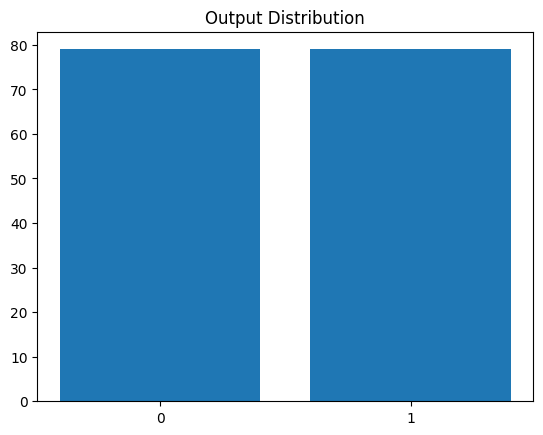

Shape of train_inputs: (158, 256, 256, 3)
Shape of test_inputs: (158,)
Shape of train_inputs: (126, 256, 256, 3)
Shape of test_inputs: (32, 256, 256, 3)
Accuraccy: 0.71875
Precision: 0.7424242424242424
Recall: 0.71875
F1 score: 0.7117117117117118
Sepia
Sepia
Sepia
Normal
Sepia
Sepia


In [ ]:
real_images_path = "normal_anime_data"
sepia_images_path = "sepia_anime_data"

normal_inputs, normal_outputs = load_image_data(real_images_path)
sepia_inputs, sepia_outputs = load_image_data(sepia_images_path)


inputs = normal_inputs + sepia_inputs
outputs = normal_outputs + sepia_outputs


plot_histogram(outputs, "Output Distribution")

print("Shape of train_inputs:", np.shape(inputs))
print("Shape of test_inputs:", np.shape(outputs))
train_inputs, train_outputs, test_inputs, test_outputs = split_data(inputs, outputs)

print("Shape of train_inputs:", train_inputs.shape)
print("Shape of test_inputs:", test_inputs.shape)

train_inputs = flatten_images(train_inputs)
test_inputs = flatten_images(test_inputs)

train_inputs, test_inputs = normalize_data(train_inputs, test_inputs)

modelType = 'x'
if (modelType == 'tool'):
    model = MLPClassifier(hidden_layer_sizes=(15,), activation='tanh', max_iter=100, solver='sgd',
                          verbose=1, random_state=1, learning_rate_init=.001)
    model.fit(train_inputs, train_outputs)
else:
    model = MyMLPClassifier(hidden_layer_sizes=(50,), activation='relu', max_iter=300, verbose=5, random_state=1,
                            learning_rate_init=.01)
    model.fit(train_inputs, train_outputs)

# input_shape = (256, 256, 3)
# num_classes = 2
# model = CNNModel(input_shape, num_classes)
# model.train(train_inputs, train_outputs, learning_rate=0.001, epochs=10)
predicted_labels = model.predict(test_inputs)

accuracy = accuracy_score(test_outputs, predicted_labels)
precision = precision_score(test_outputs, predicted_labels, average='weighted', zero_division=1)
recall = recall_score(test_outputs, predicted_labels, average='weighted', zero_division=1)
f1 = f1_score(test_outputs, predicted_labels, average='weighted', zero_division=1)

print(f'Accuraccy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 score: {f1}')

print(predict_image(model, 'sepia_data/Kangaroo/Kangaroo_2.jpg'))
print(predict_image(model, 'sepia_data/Giraffe/Giraffe_2.jpg'))
print(predict_image(model, 'sepia_data/Cow/Cow_2.jpg'))
print(predict_image(model, 'normal_data/Dolphin/Dolphin_1.jpg'))
print(predict_image(model, 'normal_data/Horse/Horse_4.jpg'))
print(predict_image(model, 'normal_data/Dog/Dog_4_1.jpg'))

# 500 iteratii
# Shape of train_inputs: (158, 256, 256, 3)
# Shape of test_inputs: (158,)
# Shape of train_inputs: (126, 256, 256, 3)
# Shape of test_inputs: (32, 256, 256, 3)
# Accuraccy: 0.84375
# Precision: 0.8595588235294118
# Recall: 0.84375
# F1 score: 0.844208211143695
# Sepia
# Sepia
# Sepia
# Normal
# Sepia
# Sepia
# 50 neuroni/strat
# Shape of train_inputs: (158, 256, 256, 3)
# Shape of test_inputs: (158,)
# Shape of train_inputs: (126, 256, 256, 3)
# Shape of test_inputs: (32, 256, 256, 3)
# Accuraccy: 0.71875
# Precision: 0.7424242424242424
# Recall: 0.71875
# F1 score: 0.7117117117117118
# Sepia
# Sepia
# Sepia
# Normal
# Sepia
# Sepia
